#### Customer data

In [1]:
# Importing lots of stuff

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (BayesRidgeRegressor)                
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
from sklearn import preprocessing
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

/home/markus/.local/lib/python3.8/site-packages/iotfunctions/bif.py:1884: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


#### Merging data first

If you have already created the merge file BP_Data/full.csv skip the next two cells

In [2]:
'''
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('./BP_DATA/BR-EH-1357_electricityData.csv', parse_dates=['dateTime'])
df_i['timestamp'] = pd.to_datetime(df_i['dateTime'], utc = True)
df_i['entity'] = 'Demand'
df_i['value'] = df_i['Real Demand (kW)']
df_i = df_i.drop(columns=['dateTime'])
df_i.set_index(['entity','timestamp'], inplace=True)




df_i.head(2)

for cnt in range(1,108):
    num = str(cnt).zfill(3)
    name = './BP_DATA/BR-EH-1357_automationData_' + str(cnt).zfill(3) + '.csv'
    print ('Merge', name)

    df_temp = pd.read_csv(name, parse_dates=['timestamp']).drop(columns=['siteName'])
    df_temp.rename(columns={'varName':'entity', 'varValue': 'value'}, inplace=True)
    df_temp.set_index(['entity','timestamp'], inplace=True)
    #df_temp
    
    
    
    #df_temp.index.rename('timestamp', inplace=True)
    df_i = df_i.merge(df_temp, on=['entity','timestamp','value'],how='outer')
    #print(df_i.shape)
    
#df_temp.head(10)
#df_i.head(10)
'''

"\n# Run on the good pump first \n# Get stuff in\ndf_i = pd.read_csv('./BP_DATA/BR-EH-1357_electricityData.csv', parse_dates=['dateTime'])\ndf_i['timestamp'] = pd.to_datetime(df_i['dateTime'], utc = True)\ndf_i['entity'] = 'Demand'\ndf_i['value'] = df_i['Real Demand (kW)']\ndf_i = df_i.drop(columns=['dateTime'])\ndf_i.set_index(['entity','timestamp'], inplace=True)\n\n\n\n\ndf_i.head(2)\n\nfor cnt in range(1,108):\n    num = str(cnt).zfill(3)\n    name = './BP_DATA/BR-EH-1357_automationData_' + str(cnt).zfill(3) + '.csv'\n    print ('Merge', name)\n\n    df_temp = pd.read_csv(name, parse_dates=['timestamp']).drop(columns=['siteName'])\n    df_temp.rename(columns={'varName':'entity', 'varValue': 'value'}, inplace=True)\n    df_temp.set_index(['entity','timestamp'], inplace=True)\n    #df_temp\n    \n    \n    \n    #df_temp.index.rename('timestamp', inplace=True)\n    df_i = df_i.merge(df_temp, on=['entity','timestamp','value'],how='outer')\n    #print(df_i.shape)\n    \n#df_temp.head(1

In [3]:
'''
df_i.to_csv('BP_DATA/full.csv')
df_i
'''

"\ndf_i.to_csv('BP_DATA/full.csv')\ndf_i\n"

In [4]:
df_i = pd.read_csv('BP_DATA/full.csv', parse_dates=['timestamp'])

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:

df_demand = df_i[df_i['entity']=='Demand']

df_demand.set_index('timestamp', inplace=True)
df_demand


,entity,salesforceName,siteName,energySource,Real Demand (kW),value
timestamp,,,,,,
2019-09-15 00:00:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,690.480000,690.480000
2019-09-15 00:15:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,682.080000,682.080000
2019-09-15 00:30:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,687.120000,687.120000
2019-09-15 00:45:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,688.800000,688.800000
2019-09-15 01:00:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,685.440000,685.440000
...,...,...,...,...,...,...
2020-09-15 22:45:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,490.559998,490.559998
2020-09-15 23:00:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,480.480011,480.480011
2020-09-15 23:15:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,480.480011,480.480011


In [10]:
'''
plots = 1

fig, ax = plt.subplots(plots, 1, figsize=(20,6), squeeze=False)
cnt = 0
ax[cnt,0].plot(df_demand.index, df_demand['Real Demand (kW)'],linewidth=0.5,color='blue',label='Demand')
#ax[cnt,0].plot(df_i.index, df_i['MaxTemp'],linewidth=0.5,color='green',label='MaxTemp')
#ax[cnt,0].plot(df_i.index, df_i['predicted_MaxTemp'],linewidth=0.5,color='red',label='MaxTemp pred')
#ax[cnt,0].fill_between(df_i.index, df_i['predicted_MaxTemp'] - df_i['stddev_MaxTemp'],
#                df_i['predicted_MaxTemp'] + df_i['stddev_MaxTemp'], color="pink", alpha=0.3, label="predict stddev")
ax[cnt,0].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt,0].set_ylabel('BP real demand',fontsize=12,weight="bold")
cnt = 1
'''

'\nplots = 1\n\nfig, ax = plt.subplots(plots, 1, figsize=(20,6), squeeze=False)\ncnt = 0\nax[cnt,0].plot(df_demand.index, df_demand[\'Real Demand (kW)\'],linewidth=0.5,color=\'blue\',label=\'Demand\')\n#ax[cnt,0].plot(df_i.index, df_i[\'MaxTemp\'],linewidth=0.5,color=\'green\',label=\'MaxTemp\')\n#ax[cnt,0].plot(df_i.index, df_i[\'predicted_MaxTemp\'],linewidth=0.5,color=\'red\',label=\'MaxTemp pred\')\n#ax[cnt,0].fill_between(df_i.index, df_i[\'predicted_MaxTemp\'] - df_i[\'stddev_MaxTemp\'],\n#                df_i[\'predicted_MaxTemp\'] + df_i[\'stddev_MaxTemp\'], color="pink", alpha=0.3, label="predict stddev")\nax[cnt,0].legend(bbox_to_anchor=(1.1, 1.05))\nax[cnt,0].set_ylabel(\'BP real demand\',fontsize=12,weight="bold")\ncnt = 1\n'

In [11]:
df_daily = df_demand.groupby(pd.Grouper(freq='1D')).sum()
df_daily['value'] /= 4
df_daily.rename(columns={'value' : 'electricity-kWh'}, inplace=True)
df_daily

,Real Demand (kW),electricity-kWh
timestamp,,
2019-09-15 00:00:00+00:00,59233.440000,14808.360000
2019-09-16 00:00:00+00:00,37418.640000,9354.660000
2019-09-17 00:00:00+00:00,66097.920000,16524.480000
2019-09-18 00:00:00+00:00,72258.480000,18064.620000
2019-09-19 00:00:00+00:00,65078.160000,16269.540000
...,...,...
2020-09-11 00:00:00+00:00,59723.999926,14930.999982
2020-09-12 00:00:00+00:00,64567.439990,16141.859997
2020-09-13 00:00:00+00:00,63122.640122,15780.660030


#### see cs109 energy consumption prediction

https://cs109-energy.github.io/building-energy-consumption-prediction.html

/home/markus/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/markus/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


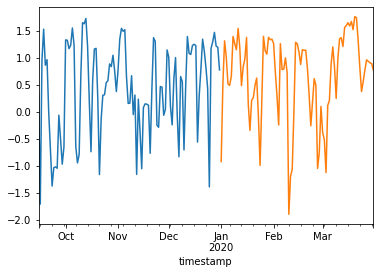

In [16]:
def addDailyTimeFeatures(df):
    df['weekday'] = df.index.weekday
    df['day'] = df.index.dayofyear
    df['week'] = df.index.weekofyear
    df['hour'] = df.index.hour
    return df
    

dailyElectricityWithFeatures = addDailyTimeFeatures(df_daily)
#print(dailyElectricityWithFeatures['electricity-kWh'].values)

sscal = preprocessing.StandardScaler()
dailyElectricityWithFeatures['consume'] = sscal.fit_transform(
    dailyElectricityWithFeatures['electricity-kWh'].values.reshape(-1, 1)).flatten()


listFeatures = ['weekday', 'day', 'week', 'hour','consume']
#df = dailyElectricityWithFeatures[['weekday', 'day', 'week', 'electricity-kWh']]
df = dailyElectricityWithFeatures[listFeatures]

#df.to_excel('Data/trainSet.xlsx')
trainSet = df['2019-01':'2019-12']
testSet = df['2020-01':'2020-03']

#normalizer = np.max(trainSet)
#trainSet = trainSet / normalizer
#testSet = testSet / normalizer
#trainX_dailyElectricity = trainSet.reset_index().index.to_numpy().reshape(-1, 1)
trainX_dailyElectricity = trainSet.values[:,0:-1]
trainY_dailyElectricity = trainSet.values[:,len(listFeatures)-1]

#testX_dailyElectricity = testSet.reset_index().index.to_numpy().reshape(-1, 1)
testX_dailyElectricity = testSet.values[:,0:-1]
testY_dailyElectricity = testSet.values[:,len(listFeatures)-1]

trainSet['consume'].plot()
testSet['consume'].plot()
#trainX_dailyElectricity



/home/markus/.local/lib/python3.8/site-packages/george/kernels.py:95: RuntimeWarning: divide by zero encountered in log
  log_constant = np.log(float(b)/self.ndim)


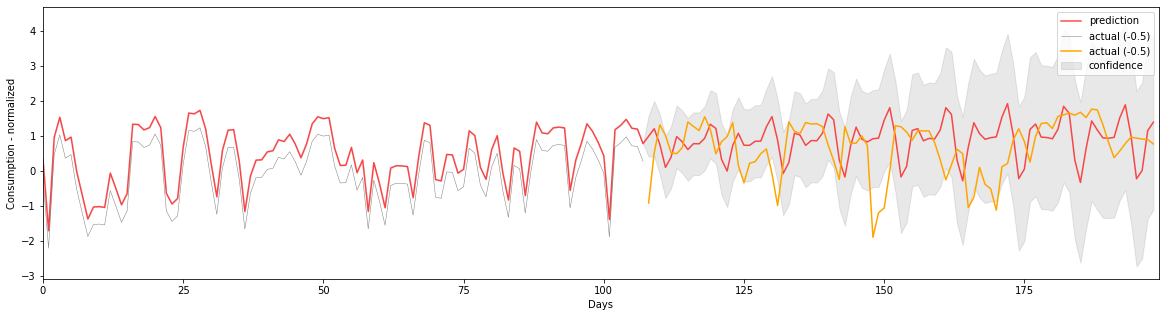

In [76]:
import george
george.__version__

from george import kernels
from sklearn.preprocessing import StandardScaler

y = trainSet['consume'].values

x = np.arange(0, y.size)
x_pred = np.arange(0, y.size + testY_dailyElectricity.size)

#kernel = np.var(y) * kernels.ExpSquaredKernel(0.5) 
kernel = 2 * kernels.CosineKernel(log_period=0.2) 
kernel = kernels.ExpSine2Kernel(gamma=0.5, log_period=2.0) # + kernels.ExpSquaredKernel(0.5) 

trend_amplitude = 0
trend_length_scale = 1
k1 = trend_amplitude **2 * kernels.ExpSquaredKernel(metric=trend_length_scale**2)

magnitude = 3.7
decay_time = 100
smoothness = 1.3
k2 = magnitude**2 * kernels.ExpSquaredKernel(decay_time**2) * kernels.ExpSine2Kernel(gamma=2/smoothness**2, log_period=0.1)

qmagnitude = 0.66
qshape = 0.78
qlength = 1.2
k3 = qmagnitude**2 * kernels.RationalQuadraticKernel(log_alpha=np.log(qshape), metric=qlength**2)

noise_level = 0.2
noise_length = 0.2
k4 = noise_level**2 * kernels.ExpSquaredKernel(noise_length**2)
kernel = k1 + k2 + k3 + k4



gp = george.GP(kernel)

gp.compute(x ) #, yerr)

gp.get_parameter_vector()


pred, pred_var = gp.predict(y, x_pred, return_var=True)
#print(pred_var)


#print (pred, pred_var)
plots = 1
fig, ax = plt.subplots(plots, 1, figsize=(20,5), squeeze=False)
cnt = 0
ax[cnt,0].fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="k", alpha=0.09,
                      label='confidence')
ax[cnt,0].plot(x_pred, pred, "-", lw=1.5, alpha=0.7, color = 'red', label='prediction')
ax[cnt,0].plot(x, y-0.5, "k", lw=0.5, alpha=0.5, label='actual (-0.5)')
ax[cnt,0].plot(np.arange(y.size, y.size + testY_dailyElectricity.size), testY_dailyElectricity, 
               color='orange', label='actual (-0.5)')
#plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#plt.plot(x_pred, np.sin(x_pred), "-g")
ax[cnt,0].set_xlim(0, x_pred.size / 1.0)
#plt.ylim(-1.45, 1.45)
ax[cnt,0].set_xlabel('Days')
ax[cnt,0].set_ylabel('Consumption - normalized')
ax[cnt,0].legend()
ax[cnt,0].title('Gaussian process with Rational Quadratic (stationary) and ')


/home/markus/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


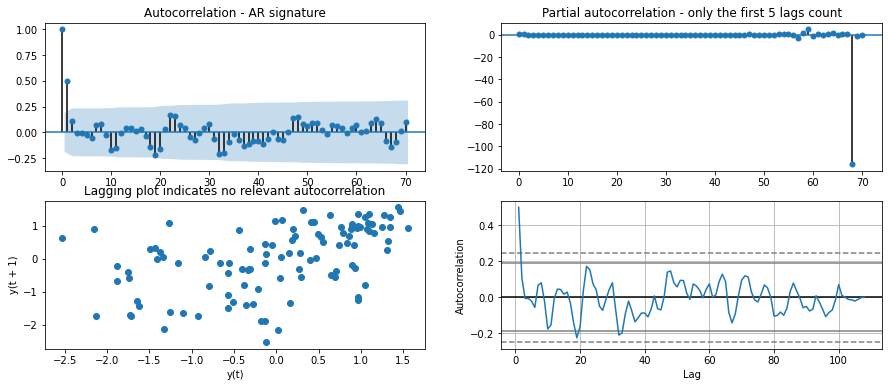

In [19]:
from statsmodels.tsa.stattools import adfuller,acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15, 6), squeeze=False)
plot_acf(y.tolist(), lags=70, alpha=.05, ax=ax[0,0], title='Autocorrelation - AR signature')
plot_pacf(y.tolist(), lags=70, alpha=.05, ax=ax[0,1], title='Partial autocorrelation - only the first 5 lags count')

df_dat = pd.DataFrame(y)

pd.plotting.lag_plot(df_dat, ax=ax[1,0], lag=1)

ax[1,0].set_title('Lagging plot indicates no relevant autocorrelation')

pd.plotting.autocorrelation_plot(df_dat, ax=ax[1,1])


In [99]:
ARIMA51model = ARIMA(y, order=(2,1 ,1))
model_fit = ARIMA51model.fit(disp=0)
print(model_fit.summary())

print(df_dat.shape, model_fit.resid.shape)

df_dat['residuals'] = np.insert(model_fit.resid, 1, 0)

df_dat['res_anom'] = np.insert(abs(model_fit.resid), 1, 0)

df_dat['arimapred'] = np.append(model_fit.predict(), 0)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  107
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -117.201
Method:                       css-mle   S.D. of innovations              0.710
Date:                Tue, 06 Oct 2020   AIC                            244.402
Time:                        09:54:13   BIC                            257.766
Sample:                             1   HQIC                           249.820
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.365      0.172      -0.002       0.012
ar.L1.D.y      0.5866      0.096      6.141      0.000       0.399       0.774
ar.L2.D.y     -0.2018      0.098     -2.068      0.0

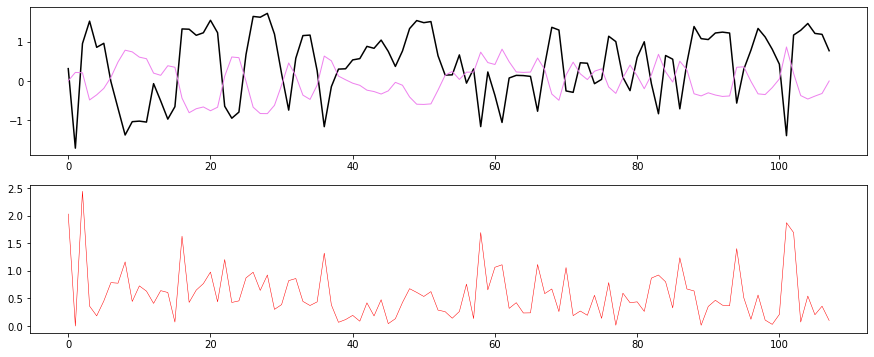

In [100]:
plots=1
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15, 6), squeeze=False)
ax[0,0].plot(x, y, color='black', label='temperature')
ax[0,0].plot(x, df_dat['arimapred'], lw=1, color='violet', label='forecast')

ax[1,0].plot(x, abs(df_dat['residuals']), lw=0.5, color='red', label='residual error')
#ax[0].scatter(df_inputm2.index, df_inputm2['res_anom']+4, lw=4, color='red')

In [ ]:
model.model.state_dict

In [127]:
p_ = gp.get_parameter_vector()
p_[0] = -10e8
gp.set_parameter_vector(p_)
print (p_)

[-1.00000000e+09  0.00000000e+00  2.61666564e+00  9.21034037e+00
  1.18343195e+00  1.00000000e-01 -8.31030888e-01 -2.48461359e-01
  3.64643114e-01 -3.21887582e+00 -3.21887582e+00]


In [128]:
import emcee


def lnprob(p):
    # Trivial uniform prior.
    if np.any((-1000 > p[1:]) + (p[1:] > 1000)):
        return -np.inf

    # Update the kernel and compute the lnlikelihood.
    gp.set_parameter_vector(p)
    return gp.lnlikelihood(y, quiet=True)


#gp.compute(t)

# Set up the sampler.
nwalkers, ndim = 36, len(gp)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
p0 = gp.get_parameter_vector() + 1e-4 * np.random.randn(nwalkers, ndim)

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 200)

print("Running production chain")
sampler.run_mcmc(p0, 200);

Running burn-in
Running production chain


In [129]:
gp.get_parameter_vector() 

array([-1.00000027e+09, -1.57676791e+02,  1.61800740e+00, -3.64806347e+02,
        3.09293157e+01,  1.19201590e+01, -6.61986464e+00,  2.27795453e+01,
        1.30313342e+01, -1.17684708e+02,  1.95019112e+02])

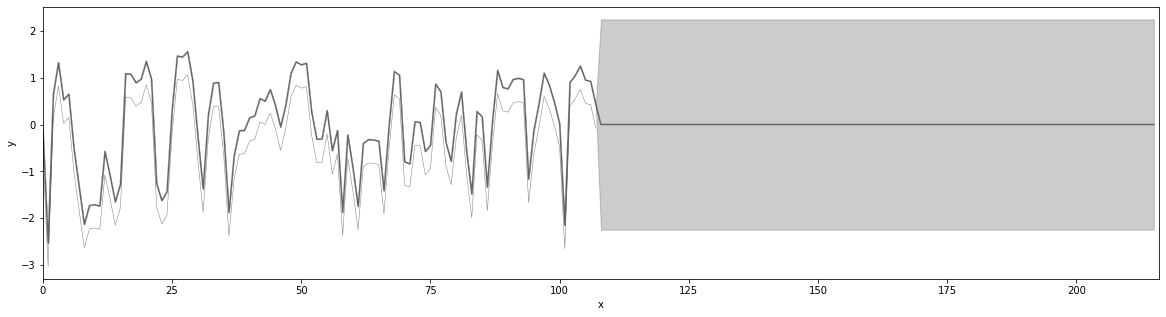

In [130]:

pred, pred_var = gp.predict(y, x_pred, return_var=True)
#print(pred_var)


#print (pred, pred_var)
plots = 1
fig, ax = plt.subplots(plots, 1, figsize=(20,5), squeeze=False)
cnt = 0
ax[cnt,0].fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="k", alpha=0.2)
ax[cnt,0].plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
ax[cnt,0].plot(x, y-0.5, "k", lw=0.5, alpha=0.5)
#plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#plt.plot(x_pred, np.sin(x_pred), "-g")
plt.xlim(0, x_pred.size)
#plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y");

In [116]:
print (gp.get_parameter_vector())

[       -inf  0.          2.61666564  9.21034037  1.18343195  0.1
 -0.83103089 -0.24846136  0.36464311 -3.21887582 -3.21887582]


In [29]:
import sklearn.decomposition
import sklearn.metrics
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, ExpSineSquared, WhiteKernel
from sklearn import model_selection



(91, 5) (91,) 0.0 0.0
Train score R2: 0.9787569528599943
Test score R2: -58.2047104779399


/home/markus/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/markus/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


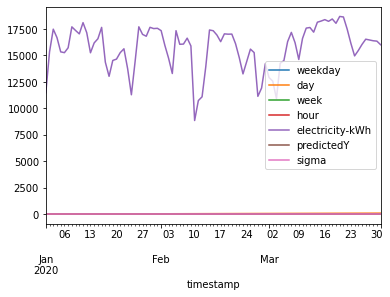

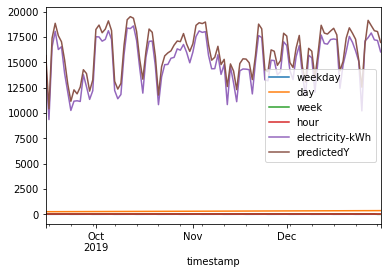

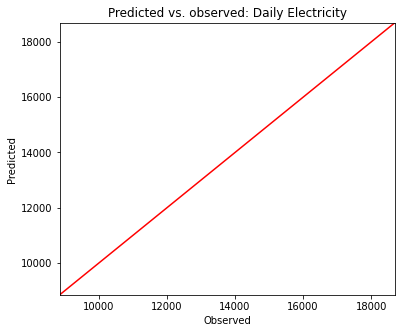

In [44]:

#kernel = gaussian_process.kernels.RBF(length_scale=0.2)
#            gaussian_process.kernels.ConstantKernel(1.0) #* 

#kernel = gaussian_process.kernels.ExpSineSquared(length_scale=0.1, periodicity=0.1)
#kernel = gaussian_process.kernels.RationalQuadratic(length_scale=0.5, alpha=0.5)
#kernel = gaussian_process.kernels.ConstantKernel(1.0) * gaussian_process.kernels.ExpSineSquared(length_scale=0.1, periodicity=0.1)

#kernel = ConstantKernel(0.1, (1e-23, 1e5)) * RBF(length_scale=0.2) + WhiteKernel(0.1, (1e-23, 1e5))

kernel = RBF(length_scale=2)


gp = gaussian_process.GaussianProcessRegressor(alpha = 10e-3, kernel=kernel, n_restarts_optimizer=10)

gp.fit(trainX_dailyElectricity, trainY_dailyElectricity)


predictedY, stddev = gp.predict(testX_dailyElectricity, return_std=True)
oldY  = gp.predict(trainX_dailyElectricity)

results = testSet.copy()
print(results.shape, predictedY.shape, min(predictedY), max(predictedY))
results['predictedY'] = predictedY
results['sigma'] = np.sqrt(stddev)
resTrain = trainSet.copy()
resTrain['predictedY'] = oldY + 1000

print("Train score R2:", gp.score(trainX_dailyElectricity, trainY_dailyElectricity))
print("Test score R2:", sklearn.metrics.r2_score(testY_dailyElectricity, predictedY))


results.plot()
resTrain.plot()

plt.figure(figsize = (6,5))
plt.scatter(testY_dailyElectricity, predictedY)
plt.plot([min(testY_dailyElectricity), max(testY_dailyElectricity)],
         [min(testY_dailyElectricity), max(testY_dailyElectricity)], 'r')
plt.xlim([min(testY_dailyElectricity), max(testY_dailyElectricity)])
plt.ylim([min(testY_dailyElectricity), max(testY_dailyElectricity)])
plt.title('Predicted vs. observed: Daily Electricity')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()
    

In [45]:
gp.kernel_.get_params()

{'length_scale': 2.130867815417103, 'length_scale_bounds': (1e-05, 100000.0)}

In [87]:
scores

array([[-0.06771299, -0.47237881, -0.69534534, -1.98642615, -0.20126418,
        -0.39702647, -2.08314569, -3.14383665, -1.62342265, -0.47315791],
       [-0.06771299, -0.47237881, -0.69534534, -1.98642615, -0.20126418,
        -0.39702647, -2.0831457 , -3.14383665, -1.62342265, -0.47315791]])

In [8]:
df_i.index.get_level_values(0).unique()

Index(['Demand', 'RACK 01 Cold Active Compressors Power %',
       'RACK 01 Cold Active Fans Power %',
       'RACK 01 Cold Condensing Calculated Setpoint',
       'RACK 01 Cold Condensing Mode', 'RACK 01 Cold Condensing Setpoint',
       'RACK 01 Cold Condensing Temperature',
       'RACK 01 Cold Maximum Condensing Setpoint',
       'RACK 01 Cold Minimum Condensing Setpoint',
       'RACK 01 Cold Offset Floating Condensing',
       ...
       'LIGHT 01 Circuit 2 Output Complement', 'LIGHT 01 Circuit 2 Status',
       'LIGHT 02 Circuit 1 Output', 'LIGHT 02 Circuit 1 Status',
       'LIGHT 02 Circuit 2 Output', 'LIGHT 02 Circuit 2 Status',
       'LIGHT 03 Circuit 1 Output', 'LIGHT 03 Circuit 1 Status',
       'LIGHT 03 Circuit 2 Output', 'LIGHT 03 Circuit 2 Status'],
      dtype='object', name='entity', length=141)

In [6]:
df_demand.reset_index(inplace=True)
from autoviz.AutoViz_Class import AutoViz_Class

Imported AutoViz_Class version: 0.0.68. Call using:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
            
To remove previous versions, perform 'pip uninstall autoviz'


In [7]:
AV = AutoViz_Class()
dft = AV.AutoViz(filename='', dfte=df_demand, verbose=1)

Shape of your Data Set: (35232, 6)
Classifying variables in data set...
('index', 'occurred at index 0')
Not able to read or load file. Please check your inputs and try again...
